In [15]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image
from torchvision.transforms import ToPILImage, Resize
import torchvision.datasets as dset
to_img  = ToPILImage()
resize_img  = Resize(200)
def show_img(img):
    return resize_img(to_img(img))

cmap=plt.cm.tab10
c = cycler('color', cmap(np.linspace(0,1,10)))
plt.rcParams["axes.prop_cycle"] = c

%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

def img_ae(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 64, 64)
    return x

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%matplotlib inline

In [12]:
dataset = dset.ImageFolder(root='/scratch/rag394/data/gaussian_generator/',
                           transform=transforms.Compose([
                                   transforms.Grayscale(),
                                   transforms.Resize(128),
                                   transforms.CenterCrop(128),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,),(0.5,)),
                               ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                         shuffle=False, num_workers=8)

targets = pd.read_csv('/scratch/rag394/data/gaussian_generator/gaussian_parameters.csv').drop(['Unnamed: 0'], 1).values
targets = Variable(torch.from_numpy(targets).type(torch.FloatTensor), requires_grad=False).cuda()

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(32*32*32, 4)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [7]:
model

CNN(
  (layer1): Sequential(
    (0): Conv2d (1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (layer2): Sequential(
    (0): Conv2d (16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  )
  (fc): Linear(in_features=32768, out_features=4)
)

In [8]:
model = CNN()
model.cuda()
optimizer = torch.optim.Adam(model.parameters(),lr=1.0e-3)
criterion = nn.SmoothL1Loss()
total_loss = []

In [10]:
model.load_state_dict(torch.load('/scratch/rag394/data/ae/conv_gaussian_encoder.pth'))

In [9]:
# torch.save(model.state_dict(), '/scratch/rag394/data/ae/conv_gaussian_encoder.pth')

In [14]:
num_epochs = 20
for epoch in range(num_epochs):
    iter_mean = []
    for k, data in enumerate(dataloader):
        if k == 2000:
            break
        img, _ = data
        img = Variable(img).cuda()
        # ===================forward=====================
        output = model(img)
        loss   = criterion(output, targets[k,:])
        
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        iter_mean.append(loss.data[0])
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch+1, num_epochs, np.mean(iter_mean)))
    total_loss.append(np.mean(iter_mean))

epoch [1/20], loss:0.0660
epoch [2/20], loss:0.0659
epoch [3/20], loss:0.0672
epoch [4/20], loss:0.0664
epoch [5/20], loss:0.0649
epoch [6/20], loss:0.0647
epoch [7/20], loss:0.0654
epoch [8/20], loss:0.0645
epoch [9/20], loss:0.0638
epoch [10/20], loss:0.0637
epoch [11/20], loss:0.0635
epoch [12/20], loss:0.0636
epoch [13/20], loss:0.0629
epoch [14/20], loss:0.0635
epoch [15/20], loss:0.0638
epoch [16/20], loss:0.0622
epoch [17/20], loss:0.0624
epoch [18/20], loss:0.0626
epoch [19/20], loss:0.0618
epoch [20/20], loss:0.0649


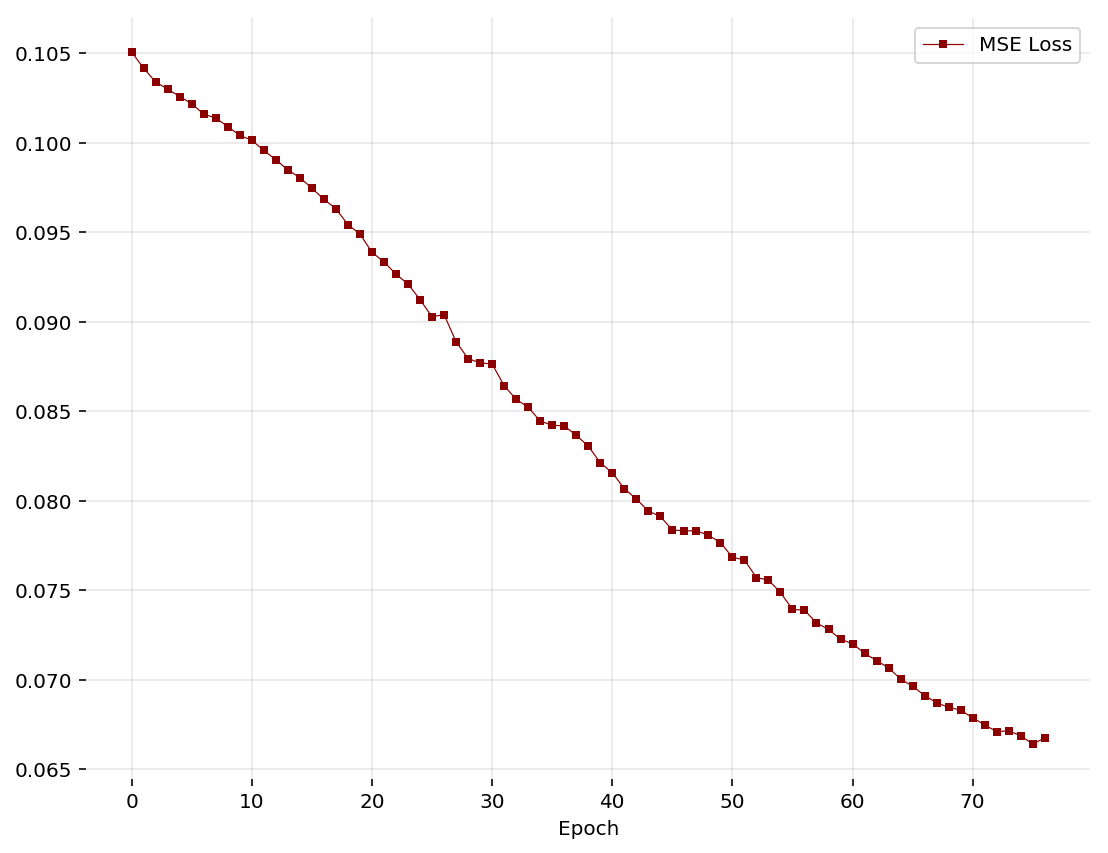

In [188]:
fig, ax = plt.subplots(figsize=(9,7))
pd.Series(total_loss[1:], name='MSE Loss').plot(ax=ax,color='darkred', 
                                            lw=0.6, marker='s', markersize=3., legend=True)
ax.grid(alpha=0.2)
ax.set_xlabel('Epoch')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_alpha(False)
ax.grid(alpha=0.3)

/home/rag394/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: covariance is not positive-semidefinite.
  from ipykernel import kernelapp as app


[[ 0.6897 -0.6209]
 [-0.6209  0.5665]]

[[ 0.28151274 -0.37736097]
 [-0.3771286   0.7086081 ]]


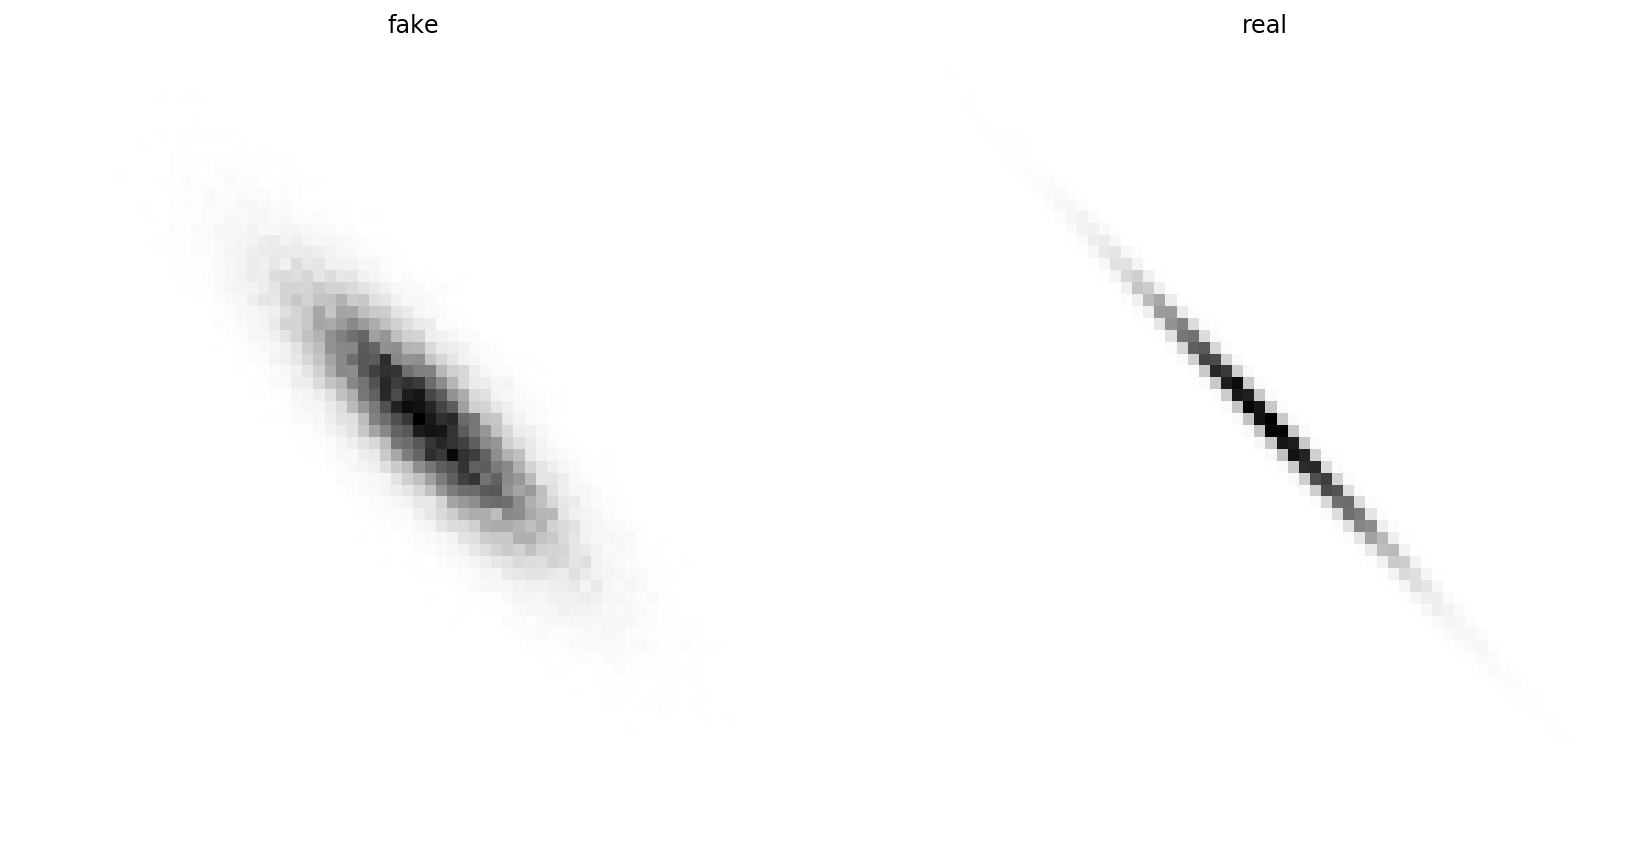

In [13]:
for k, data in enumerate(dataloader):
        if k == 11:
            img, _ = data
            img = Variable(img).cuda()
            real = targets[k,:]
            output = model(img)
            error = criterion(output, real)
            break

cov_fake = output.view(2,2)
cov_real = real.view(2,2)

fig, ax = plt.subplots(ncols=2, figsize=(14,7),frameon=False)

x, y = np.random.multivariate_normal([0, 0], cov_fake.data.cpu().numpy(), 50000).T

ax[0].hist2d(x,y,bins=64,cmap='Greys');
ax[0].axis('off')
ax[0].set_title('fake')

x, y = np.random.multivariate_normal([0, 0], cov_real.data.cpu().numpy(), 50000).T

ax[1].hist2d(x,y,bins=64,cmap='Greys');
ax[1].axis('off')
ax[1].set_title('real')

print(cov_real.data.cpu().numpy())
print('')
print(cov_fake.data.cpu().numpy());